## Perturbation of sequences
### Dataset: UniProt SARS-CoV-2 aligned w.r.t WIV04
### Number of sequences = 
### Model: VirProBERT (CoV-S-UniRef90, CoV-S-UniRef90-aligned) 

In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

['/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/sars-cov-2/uniprot',
 '/opt/conda/lib/python38.zip',
 '/opt/conda/lib/python3.8',
 '/opt/conda/lib/python3.8/lib-dynload',
 '',
 '/home/blessyantony/.local/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages/IPython/extensions',
 '/home/blessyantony/.ipython',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/sars-cov-2/uniprot/../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/sars-cov-2/uniprot/../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/sars-cov-2/uniprot/..']

In [2]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import re

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
cmap = sns.color_palette("vlag", as_cmap=True)

from Bio import SeqIO
from Bio.Seq import Seq
from Bio import motifs


In [3]:
human_label = "Human"
pred_diff_col = f"{human_label}_pred_diff"
perturbation_processed_output_dir = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_perturbation/20240320/sars-cov-2/uniprot/cov-S-aligned-binary-transfer_learning_mlm_fnn_2l_lr1e-4/processed")
perturbation_output_files = os.listdir(perturbation_processed_output_dir)
len(perturbation_output_files)

1019

In [4]:
perturbed_output_dfs = []
for perturbation_output_file in perturbation_output_files:
    df = pd.read_csv(os.path.join(perturbation_processed_output_dir, perturbation_output_file))
    orig_seq_df = df[df["orig_token"] == df["new_token"]]
    orig_pred_val = orig_seq_df[human_label].values[0]
    df[pred_diff_col] = df[human_label] - orig_pred_val
    df[f"abs_{pred_diff_col}"] = df[pred_diff_col].abs()
    perturbed_output_dfs.append(df)
perturbed_output_df = pd.concat(perturbed_output_dfs)

In [5]:
print(perturbed_output_df.shape)
perturbed_output_df.head()

(32347819, 9)


,Human,Non-Human,uniprot_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff
0,0.978952,0.021048,A0A8B6RKP4,Human,A,1324,N,0.000134,0.000134
1,0.978818,0.021182,A0A8B6RKP4,Human,K,1573,T,0.000000,0.000000
2,0.978822,0.021178,A0A8B6RKP4,Human,Q,1170,G,0.000005,0.000005
3,0.978853,0.021147,A0A8B6RKP4,Human,V,923,I,0.000035,0.000035
4,0.978818,0.021182,A0A8B6RKP4,Human,A,1622,B,0.000000,0.000000


### WIV04 reference sequence

In [6]:
wiv04_aligned_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "input/data/coronaviridae/20240313/uniprot/aligned/coronaviridae_s_uniprot_uniprot_metadata_embl_hosts_pruned_metadata_corrected_species_virus_host_vertebrates_w_seq_t0.01_c8_aligned.csv")
wiv04_df = pd.read_csv(wiv04_aligned_file_path)
wiv04_df = wiv04_df[wiv04_df["uniprot_id"] == "WIV04"]
wiv04_df.head()

,uniprot_id,aligned_seq,seq,virus_name,virus_host_name,human_binary_label
0,WIV04,-----MFVFLVLLPLVS---------------------------SQ...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,WIV04(MN996528.1) Wuhan variant index virus,homo sapiens,homo sapiens


In [7]:
wiv04_aligned_seq = wiv04_df["aligned_seq"].values[0]
wiv04_aligned_seq

'-----MFVFLVLLPLVS---------------------------SQCVNLTTRTQLPP--AYTN--SFTR-----------------------------GVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNI-----IRGWIFGTTLDS----------KTQSLLIVNNAT----------N--------------VVIKVCEFQFCN-----------------------------------------------------------------DPFLGVY--------YHKNNK--------SWMESEF-RVYSS-----ANNCT-----FEYVSQP--FLMDLEGKQGNFK-------------NLREFVFK-NIDGYFKIYSKHTPINL---VRD-------------------------LPQGFS-------------------ALEPLV-----------------------------------DLPIGI--------NIT---------------------------------RFQTLLALHRSYLT-----PGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQ----PTESI---VRF-----PNITNLC----PFGEVF-------------------NATR-------------FASVYAWNRK-----------RISNCVADYSVLYNS-ASFSTFKC-----------YGVSPTKL----------------------NDLCFTNVYADSF----------VIRGD-------------------EVR-QIA----------PGQTGKI------ADYNYKLPDDFT--------G----CV----------IA-------WNSNNLDSKVGGNYNYLY---RLFRKSNL-----KPFERDISTEIYQAGST-----

In [8]:
wiv04_position_mapping = {}
pos = 0
for i, token in enumerate(wiv04_aligned_seq):
    if token == "-":
        continue
    else:
        pos += 1
        wiv04_position_mapping[i] = pos
        
try:
    perturbed_output_df["perturb_seq_pos"] = perturbed_output_df["perturb_pos"].apply(lambda x: int(wiv04_position_mapping[x]) if x in wiv04_position_mapping else None)
except: 
    pass

### Distribution of prediction difference values

In [9]:
# plt.clf()
# plt.figure(figsize=(48, 16))
# plt.rcParams['xtick.labelsize'] = 24
# plt.rcParams['ytick.labelsize'] = 24
# sns.distplot(perturbed_output_df["Human_pred_diff"])
# plt.show()

In [10]:
n_bins = 12
n = perturbed_output_df.shape[0]
freq, bins = np.histogram(perturbed_output_df[pred_diff_col], bins=n_bins)
hist_map = []
for i in range(n_bins):
    hist_map.append({"start": bins[i], "end":bins[i+1], "count": freq[i], "percentage": freq[i]/n*100})
    
hist_df = pd.DataFrame(hist_map)
hist_df.head(20)

,start,end,count,percentage
0,-0.762564,-0.690810,5,0.000015
1,-0.690810,-0.619056,6,0.000019
2,-0.619056,-0.547302,5,0.000015
3,-0.547302,-0.475548,7,0.000022
4,-0.475548,-0.403794,172,0.000532
5,-0.403794,-0.332040,26,0.000080
6,-0.332040,-0.260286,13,0.000040
7,-0.260286,-0.188532,97,0.000300
8,-0.188532,-0.116778,361,0.001116
9,-0.116778,-0.045024,893,0.002761


In [11]:
perturbed_output_df_selected = perturbed_output_df[perturbed_output_df[f"abs_{pred_diff_col}"] > 0.1]
print(f"Number of sequences = {perturbed_output_df_selected.shape[0]}")
print(f"Number of unique positions = {len(perturbed_output_df_selected['perturb_seq_pos'].unique())}")
print(f"Unique positions = {perturbed_output_df_selected['perturb_seq_pos'].unique()}")

Number of sequences = 761
Number of unique positions = 4
Unique positions = [517. 513. 533. 502.]


In [12]:
perturbed_output_df_selected["experiment"] = "sarscov2-uniprot-aligned-binary"
perturbation_selected_output_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_perturbation/20240320/sars-cov-2/analysis/uniprot_aligned_binary.csv")
perturbed_output_df_selected.to_csv(perturbation_selected_output_file_path, index=False)

/tmp/ipykernel_279001/3081544423.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perturbed_output_df_selected["experiment"] = "sarscov2-uniprot-aligned-binary"


### Top 10 perturbations with highest change in prediction probability

In [13]:
perturbed_output_df_selected.sort_values(by="abs_Human_pred_diff", ascending=False).head(10)


,Human,Non-Human,uniprot_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff,perturb_seq_pos,experiment
16306,0.205657,0.794343,A0A7U3MR70,Human,L,1124,R,-0.762564,0.762564,533.0,sarscov2-uniprot-aligned-binary
11608,0.211700,0.788300,A0A7U3MRY6,Human,L,1124,R,-0.756378,0.756378,533.0,sarscov2-uniprot-aligned-binary
17828,0.211700,0.788300,A0A7U3MRZ9,Human,L,1124,R,-0.756378,0.756378,533.0,sarscov2-uniprot-aligned-binary
25817,0.211700,0.788300,A0A7U3MS26,Human,L,1124,R,-0.756378,0.756378,533.0,sarscov2-uniprot-aligned-binary
15624,0.222376,0.777624,A0A7U3MRK2,Human,L,1124,R,-0.746344,0.746344,533.0,sarscov2-uniprot-aligned-binary
5509,0.279408,0.720592,A0A7D4XSL8,Human,L,1124,R,-0.689249,0.689249,533.0,sarscov2-uniprot-aligned-binary
26887,0.286713,0.713287,A0A7U3MS27,Human,L,1124,R,-0.682544,0.682544,533.0,sarscov2-uniprot-aligned-binary
13622,0.301248,0.698752,A0A8B6RWV4,Human,L,1124,R,-0.667096,0.667096,533.0,sarscov2-uniprot-aligned-binary
30290,0.304969,0.695031,A0A7U3H6A7,Human,L,1124,R,-0.663762,0.663762,533.0,sarscov2-uniprot-aligned-binary
27863,0.320786,0.679214,A0A7U3EBP1,Human,L,1124,R,-0.648574,0.648574,533.0,sarscov2-uniprot-aligned-binary


In [14]:
perturbed_output_df_selected["perturbation_id"] = perturbed_output_df_selected.apply(lambda x: f"{x['perturb_seq_pos']}_{x['new_token']}", axis=1)
perturbed_output_df_selected.head()

/tmp/ipykernel_279001/2825421286.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perturbed_output_df_selected["perturbation_id"] = perturbed_output_df_selected.apply(lambda x: f"{x['perturb_seq_pos']}_{x['new_token']}", axis=1)


,Human,Non-Human,uniprot_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff,perturb_seq_pos,experiment,perturbation_id
12051,0.449116,0.550884,A0A7L9CHP7,Human,L,1101,R,-0.436667,0.436667,517.0,sarscov2-uniprot-aligned-binary,517.0_R
15633,0.736900,0.263100,A0A7L9CHP7,Human,L,1097,R,-0.148883,0.148883,513.0,sarscov2-uniprot-aligned-binary,513.0_R
1990,0.568825,0.431175,A0A7L9VWI5,Human,L,1101,R,-0.324766,0.324766,517.0,sarscov2-uniprot-aligned-binary,517.0_R
8876,0.778404,0.221596,A0A7L9VWI5,Human,L,1097,R,-0.115187,0.115187,513.0,sarscov2-uniprot-aligned-binary,513.0_R
3296,0.848765,0.151235,A0A7U3MRK2,Human,L,1124,D,-0.119954,0.119954,533.0,sarscov2-uniprot-aligned-binary,533.0_D


In [15]:
mean_diff_df = perturbed_output_df_selected[["perturbation_id", "abs_Human_pred_diff"]].groupby("perturbation_id").mean(pred_diff_col)

In [16]:
mean_diff_df = mean_diff_df.reset_index()

In [17]:
mean_diff_df[["perturb_seq_pos", "new_token"]] = mean_diff_df["perturbation_id"].str.split("_", expand=True)

In [18]:
mean_diff_df.head()

,perturbation_id,abs_Human_pred_diff,perturb_seq_pos,new_token
0,502.0_D,0.101086,502.0,D
1,513.0_A,0.100356,513.0,A
2,513.0_G,0.111945,513.0,G
3,513.0_M,0.100065,513.0,M
4,513.0_R,0.144133,513.0,R


In [19]:
mean_diff_df[mean_diff_df[["perturb_seq_pos", "new_token"]].duplicated()]

,perturbation_id,abs_Human_pred_diff,perturb_seq_pos,new_token


In [20]:
df = mean_diff_df.pivot(columns="perturb_seq_pos", index="new_token", values="abs_Human_pred_diff")
# df[token_positions]

In [21]:
mean_diff_df.sort_values(by="abs_Human_pred_diff", ascending=False).head(10)

,perturbation_id,abs_Human_pred_diff,perturb_seq_pos,new_token
26,533.0_R,0.560895,533.0,R
9,517.0_R,0.418476,517.0,R
31,533.0_W,0.251190,533.0,W
20,533.0_K,0.190481,533.0,K
16,533.0_G,0.180741,533.0,G
32,533.0_X,0.165909,533.0,X
12,533.0_C,0.165236,533.0,C
25,533.0_Q,0.162974,533.0,Q
24,533.0_P,0.162927,533.0,P
33,533.0_Y,0.159098,533.0,Y


<Figure size 432x288 with 0 Axes>

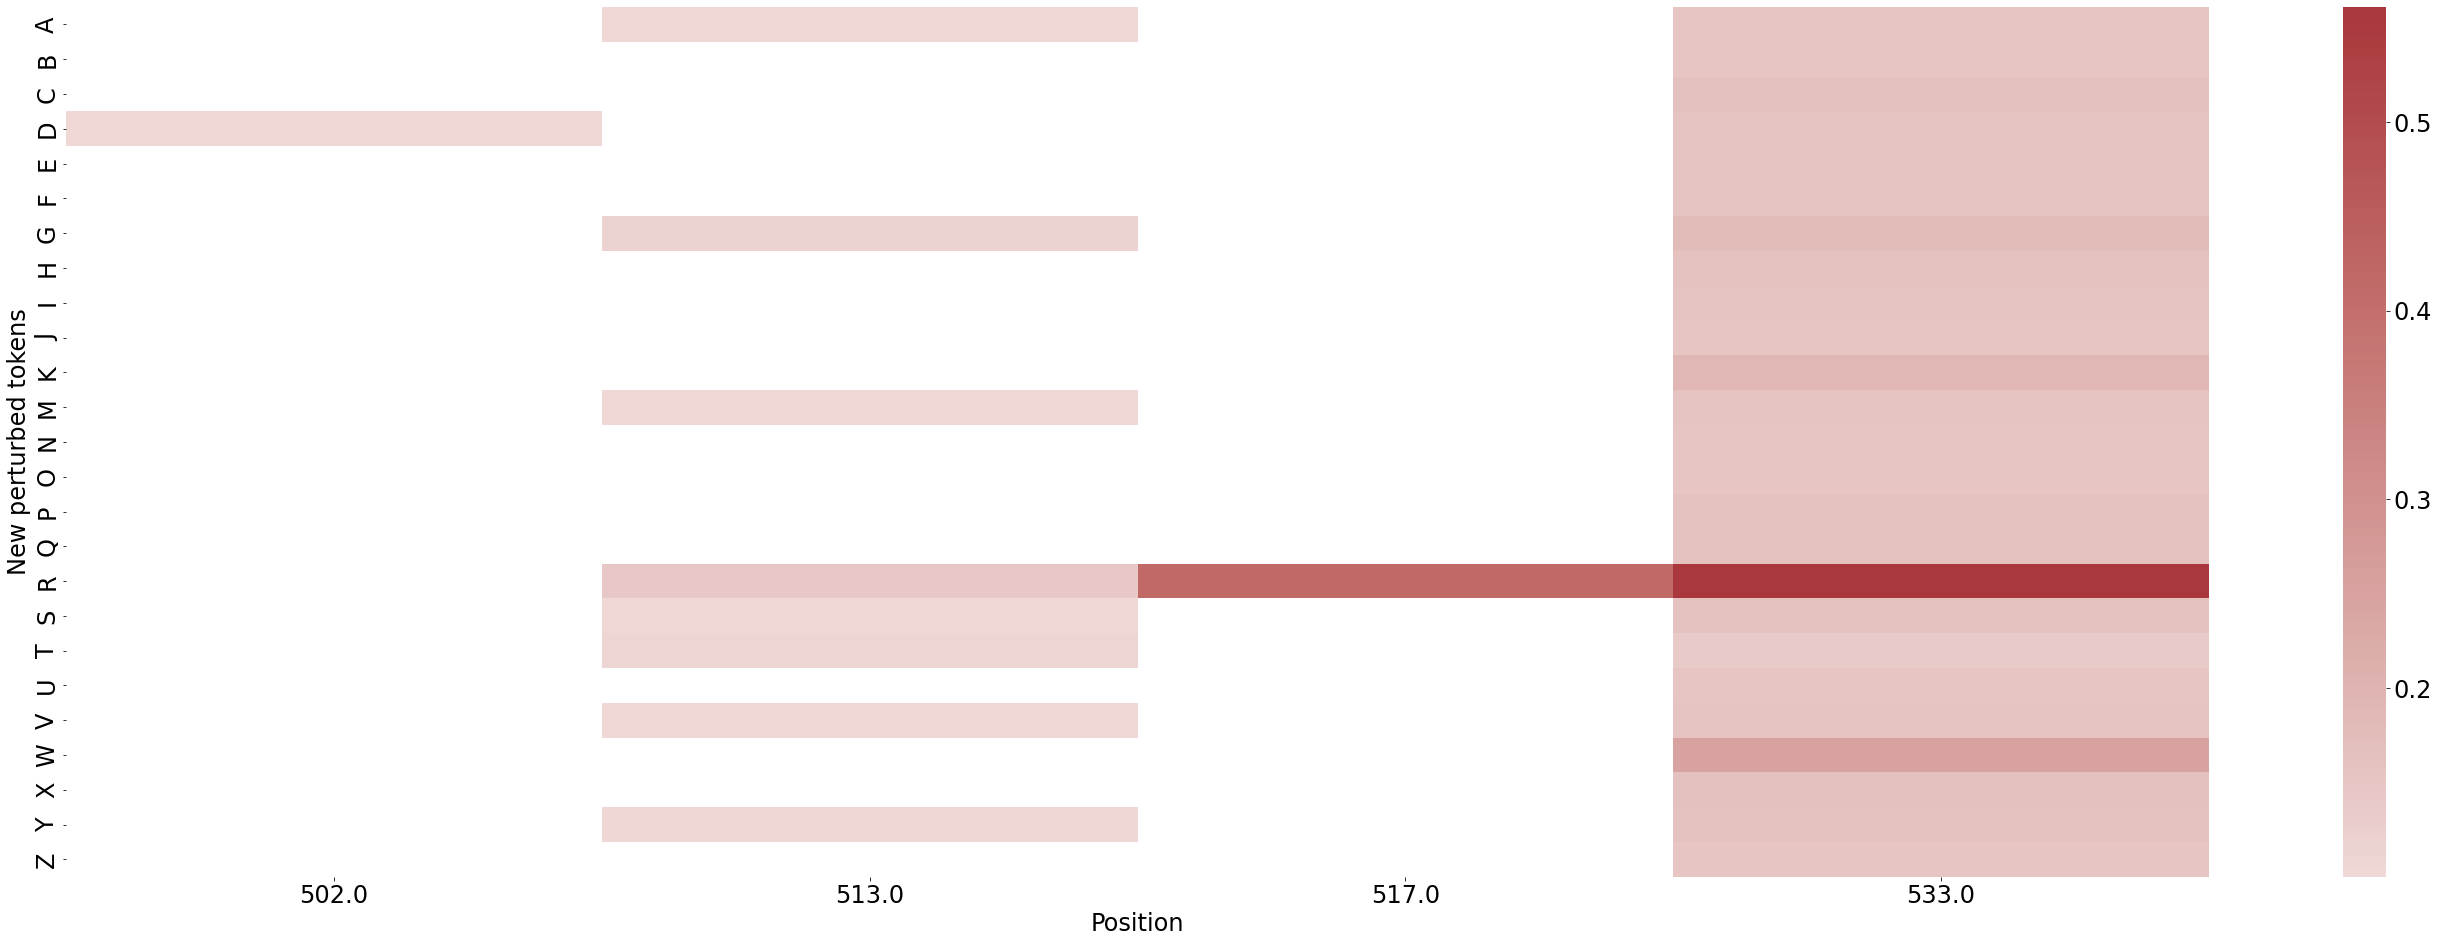

In [22]:
plt.clf()
plt.figure(figsize=(48, 16))
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
# plt.rcParams['figure.autolayout'] = True
ax = sns.heatmap(df, cmap=cmap, center=0)
plt.xlabel('Position', fontsize=24)
plt.ylabel('New perturbed tokens', fontsize=24)
plt.show()

In [23]:
df.mean(axis=0)

perturb_seq_pos
502.0    0.101086
513.0    0.108124
517.0    0.418476
533.0    0.178572
dtype: float64

<Figure size 432x288 with 0 Axes>

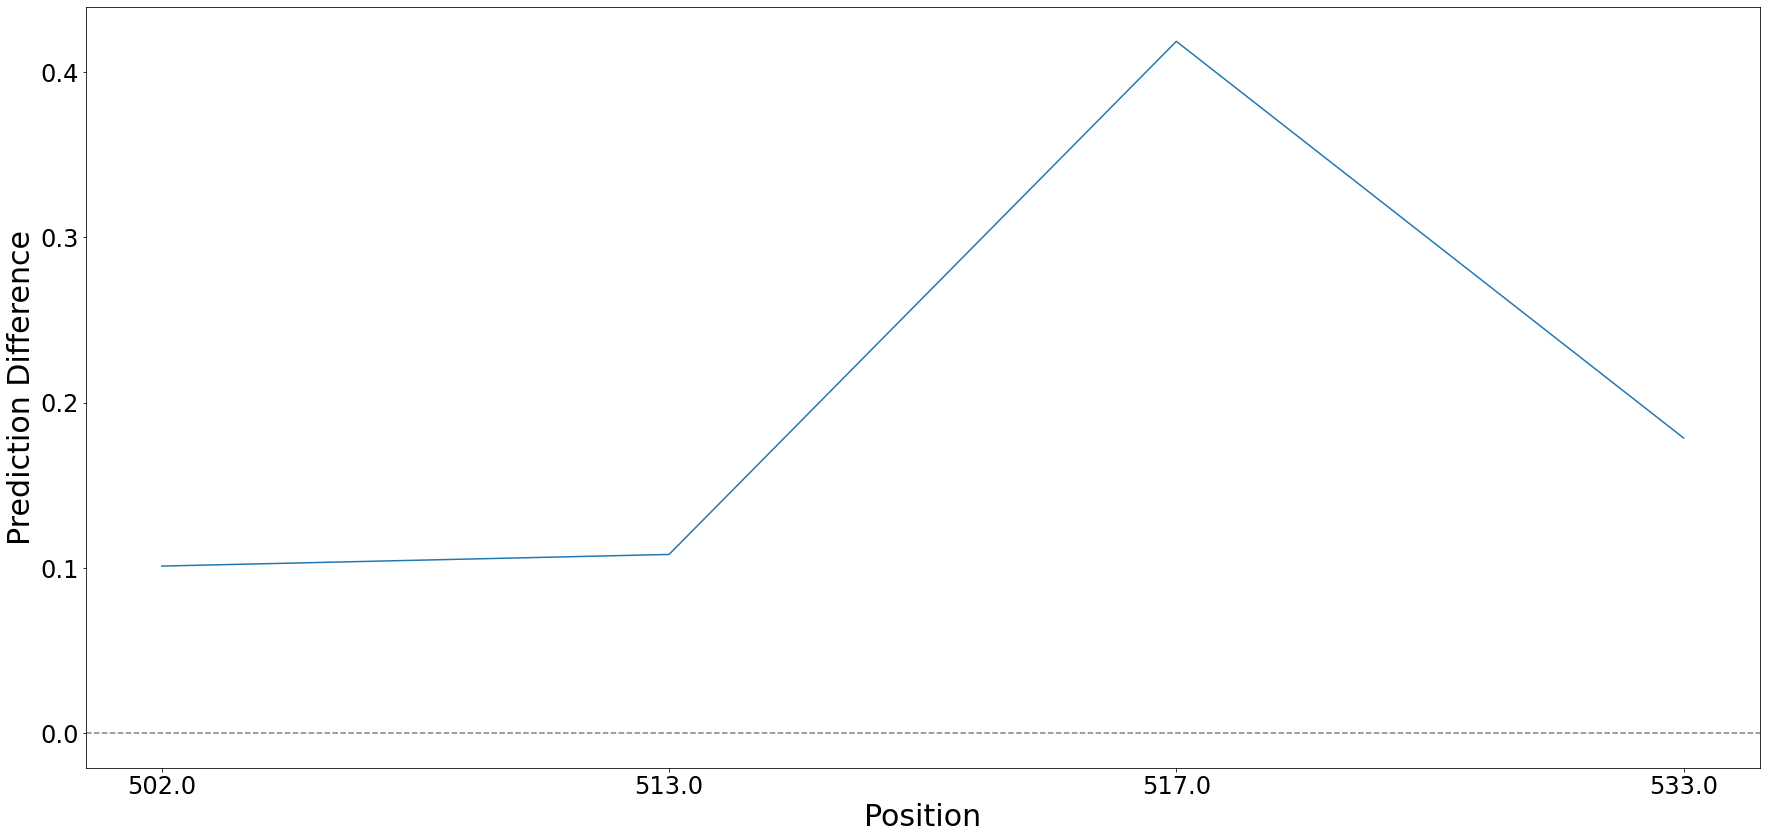

In [24]:
plt.clf()
plt.figure(figsize=(30, 14))
ax = sns.lineplot(df.mean(axis=0))
ax.axhline(0.0, color="gray", linestyle="--")
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.xlabel('Position', fontsize=30)
plt.ylabel('Prediction Difference', fontsize=30)
#ax.set_xlim(0, 1273)
plt.show()